## AI Agent - Email Drafter:

For the company, you need to create an AI Agentic System that can speed up drafting documents, emails, etc. 

It should have:
- Human-AI collaboration i.e. human should be able to provide continous feedback.
- AI should stop when the human is happy with the draft.
- System should be able to save the draf.

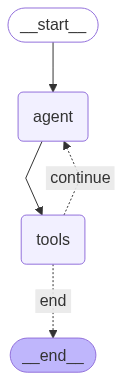

<!-- **Imports:** -->

In [1]:
# typing
from typing import Annotated, Sequence, TypedDict

# langchain
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_ollama import ChatOllama
from langchain_core.tools import tool

# langgraph
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

**Agent State And Tools:**

In [2]:
# This is the global variable to store document content
document_content = ""

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]


@tool
def update(content: str) -> str:
    """Updates the document with the provided content."""
    global document_content
    document_content = content
    return f"Document has been updated successfully! The current content is:\n{document_content}"


@tool
def save(filename: str) -> str:
    """Save the current document to a text file and finish the process.
    
    Args:
        filename: Name for the text file.
    """

    global document_content

    if not filename.endswith('.txt'):
        filename = f"{filename}.txt"


    try:
        with open(filename, 'w') as file:
            file.write(document_content)
        print(f"\n💾 Document has been saved to: {filename}")
        return f"Document has been saved successfully to '{filename}'."
    
    except Exception as e:
        return f"Error saving document: {str(e)}"
    

tools = [update, save]

**Model:**

In [3]:
model_name = "llama3.1:latest"
model = ChatOllama(model=model_name).bind_tools(tools)

**Node Functions:**

In [4]:
# Entry Node
def our_agent(state: AgentState) -> AgentState:
    system_prompt = SystemMessage(content=f"""
    You are Drafter, a helpful writing assistant. You are going to help the user update and modify documents.
    
    - If the user wants to update or modify content, use the 'update' tool with the complete updated content.
    - If the user wants to save and finish, you need to use the 'save' tool.
    - Make sure to always show the current document state after modifications.
    
    The current document content is:{document_content}
    """)

    if not state["messages"]:
        user_input = "I'm ready to help you update a document. What would you like to create?"
        user_message = HumanMessage(content=user_input)

    else:
        user_input = input("\nWhat would you like to do with the document? ")
        print(f"\n👤 USER: {user_input}")
        user_message = HumanMessage(content=user_input)

    all_messages = [system_prompt] + list(state["messages"]) + [user_message]

    response = model.invoke(all_messages)

    print(f"\n🤖 AI: {response.content}")
    if hasattr(response, "tool_calls") and response.tool_calls:
        print(f"🔧 USING TOOLS: {[tc['name'] for tc in response.tool_calls]}")

    return {"messages": list(state["messages"]) + [user_message, response]}


# Conditional Edge Function
def should_continue(state: AgentState) -> str:
    """Determine if we should continue or end the conversation."""

    messages = state["messages"]
    
    if not messages:
        return "continue"
    
    # This looks for the most recent tool message....
    for message in reversed(messages):
        # ... and checks if this is a ToolMessage resulting from save
        if (isinstance(message, ToolMessage) and 
            "saved" in message.content.lower() and
            "document" in message.content.lower()):
            return "end" # goes to the end edge which leads to the endpoint
        
    return "continue"

In [5]:
graph = StateGraph(AgentState)

# node
graph.add_node("agent", our_agent)
graph.add_node("tools", ToolNode(tools))

# entry
graph.set_entry_point("agent")

# edges
graph.add_edge("agent", "tools")
graph.add_conditional_edges(
    "tools",
    should_continue,
    {
        "continue": "agent",
        "end": END,
    },
)

agent = graph.compile()


def print_messages(messages):
    """Function I made to print the messages in a more readable format"""
    if not messages:
        return
    
    for message in messages[-3:]:
        if isinstance(message, ToolMessage):
            print(f"\n🛠️ TOOL RESULT: {message.content}")


**Execute and Agent:**

In [6]:
print("\n ===== DRAFTER =====")

state = {"messages": []}

for step in agent.stream(state, stream_mode="values"):
    if "messages" in step:
        print_messages(step["messages"])

print("\n ===== DRAFTER FINISHED =====")


 ===== DRAFTER =====

🤖 AI: 
🔧 USING TOOLS: ['update']

🛠️ TOOL RESULT: Document has been updated successfully! The current content is:
The updated content is:

The Cutting Knowledge Date has been moved to 2024.

This date indicates the last time the knowledge was cut.

👤 USER: What's the document content

🤖 AI: 
🔧 USING TOOLS: ['update']

🛠️ TOOL RESULT: Document has been updated successfully! The current content is:
The updated content is:

The Cutting Knowledge Date has been moved to 2024.

This date indicates the last time the knowledge was cut.

🛠️ TOOL RESULT: Document has been updated successfully! The current content is:
The Cutting Knowledge Date has been moved to 2024.

This date indicates the last time the knowledge was cut.

Cutting Knowledge Date: December 2023

👤 USER: save

🤖 AI: 
🔧 USING TOOLS: ['save']

🛠️ TOOL RESULT: Document has been updated successfully! The current content is:
The Cutting Knowledge Date has been moved to 2024.

This date indicates the last time t

**Agent Graph:**

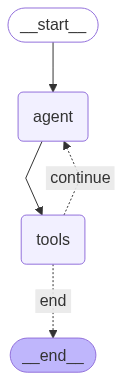

In [7]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))